# Decompose HSC observed QSO image

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy) (pip install lenstronomy)
    - note: if python2 used, lenstronomy version 1.3.0 version is recommended (pip install lenstronomy==1.3.0 --user)
- regions (pip install regions)
- photutils (pip install photutils)

This notebook has been tested with decompsofile ==  0.1.0

For more information, please contact me: dingxuheng@126.com

This notebook is very similar to the 'decomprofile_HST_QSO.ipynb', only that the noise_map, PSF are input to the fittings. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: \url, 
fitsFile = pyfits.open('../example_files/HSC/QSO/000017.88+002612.6_HSC-I.fits')

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

#Derive the fov noise level map:
err_data= fitsFile[3].data ** 0.5

#Calculate the zeropoint for HSC filters:
file_header0 = fitsFile[0].header
FLUXMAG0 = file_header0['FLUXMAG0']
zp =  2.5 * np.log10(FLUXMAG0)   # This is something Xuheng can't make sure.

#Load the PSF data:
PSF = pyfits.getdata('../example_files/HSC/QSO/000017.88+002612.6_HSC-I_psf.fits')

Plot target cut out zoom in:


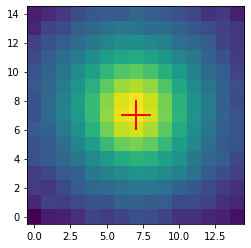

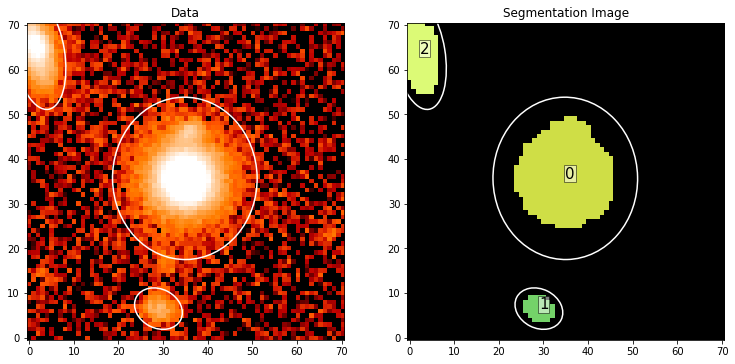

 id xcentroid ycentroid     source_sum         orientation      area
       pix       pix                               deg          pix2
--- --------- --------- ------------------ ------------------- -----
  1     28.97      6.48 15.040577443378961 -26.923383269023738  34.0
  0     34.88     35.65  948.0025201863621  -88.67991869823322 411.0
  2      2.28     63.71 102.65140894371011  -80.66442324190838 101.0
Input directly the a obj idx to mask, use space between each id:
2


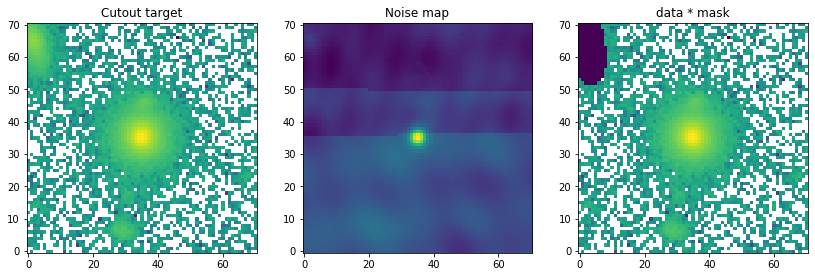

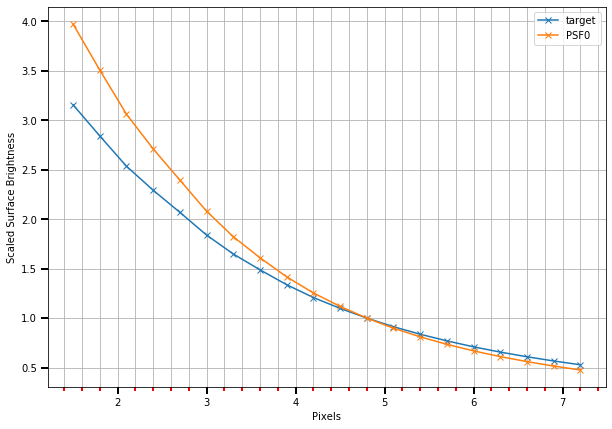

The data_process is ready to go to pass to FittingSpecify!


In [4]:
from decomprofile.data_process import DataProcess

#RA, DEC information of the QSO:
QSO_RA, QSO_DEC = 0.07452999800443649, 0.4368380010128021
data_process = DataProcess(fov_image = fov_image, fov_noise_map = err_data, target_pos = [QSO_RA, QSO_DEC],
                           pos_type = 'wcs', header = header,
                          rm_bkglight = True, if_plot=False, zp = zp)

#Manually input the fov noise map:
data_process.fov_noise_map = err_data

#Generate the fitting materials
data_process.generate_target_materials(radius=35, create_mask = True, nsigma=2.8,
                                      exp_sz= 1.5, npixels = 15, if_plot=True)

#Manually input the PSF:
data_process.PSF_list = [PSF]

# Compare the 1D profile of all the components.
data_process.profiles_compare(norm_pix = 5, if_annuli=False, y_log = False,
                  prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]) )


#Check if all the materials is given, if so to pass to the next step.
data_process.checkout() #Check if all the materials is known.

In [5]:
#Start to produce the class and params for lens fitting.
#For more details, see notebook decomprofile_HST_QSO.ipynb
from decomprofile.fitting_specify import FittingSpeficy
fit_sepc = FittingSpeficy(data_process)
fit_sepc.prepare_fitting_seq(point_source_num = 1)
#Using following line: want to fix Sersic_n as 4 for the source_id = 0, and if want to fix the QSO and host center:
# fit_sepc.prepare_fitting_seq(point_source_num = 1, fix_n_list= [[0,4]], fix_center_list = [[0,0]])
fit_sepc.build_fitting_seq()

The settings for the fitting is done. Ready to pass to FittingProcess. 
	However, please update self.settings manullay if needed.


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Max iteration reached! Stopping.
-1.4889633520721473 reduced X^2 of best position
-3627.859207323787 logL
4873.0 effective number of data points
[] lens result
[{'amp': 1, 'R_sersic': 0.9365916815875351, 'n_sersic': 1.732502937493807, 'e1': -0.06598302312525849, 'e2': 0.07435009767141187, 'center_x': 0.04516889747198464, 'center_y': 0.106218467631613}, {'amp': 1, 'R_sersic': 0.3939345037123498, 'n_sersic': 0.3343326684131287, 'e1': 0.21634270164539415, 'e2': 0.13765218960036693, 'center_x': 0.9958403617490176, 'center_y': -4.788979709191951}] source result
[] lens light result
[{'ra_image': array([0.02283648]), 'dec_image': array([0.04942358]), 'point_amp': [1]}] point source result
{} special param result
56.867090940475464 time used for  PSO


100%|██████████| 130/130 [01:01<00:00,  2.11it/s]


Computing the MCMC...
Number of walkers =  140
Burn-in iterations:  100
Sampling iterations (in current run): 130
62.174909830093384 time taken for MCMC sampling
119.059 total time taken for the overall fitting (s)
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
-1.484044825789764 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.4840448257897643
Start transfering the Params to fluxs...
4200 MCMC samplers in total, finished translate: 1000
4200 MCMC samplers in total, finished translate: 2000
4200 MCMC samplers in total, finished translate: 3000
4200 MCMC samplers in total, finished translate: 4000


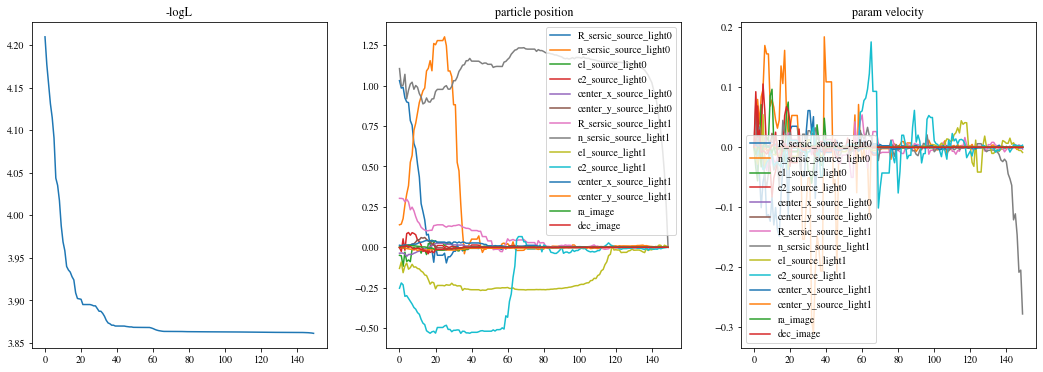

<Figure size 432x288 with 0 Axes>

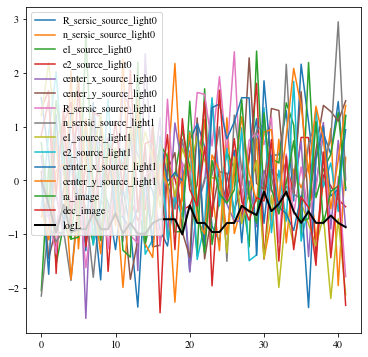

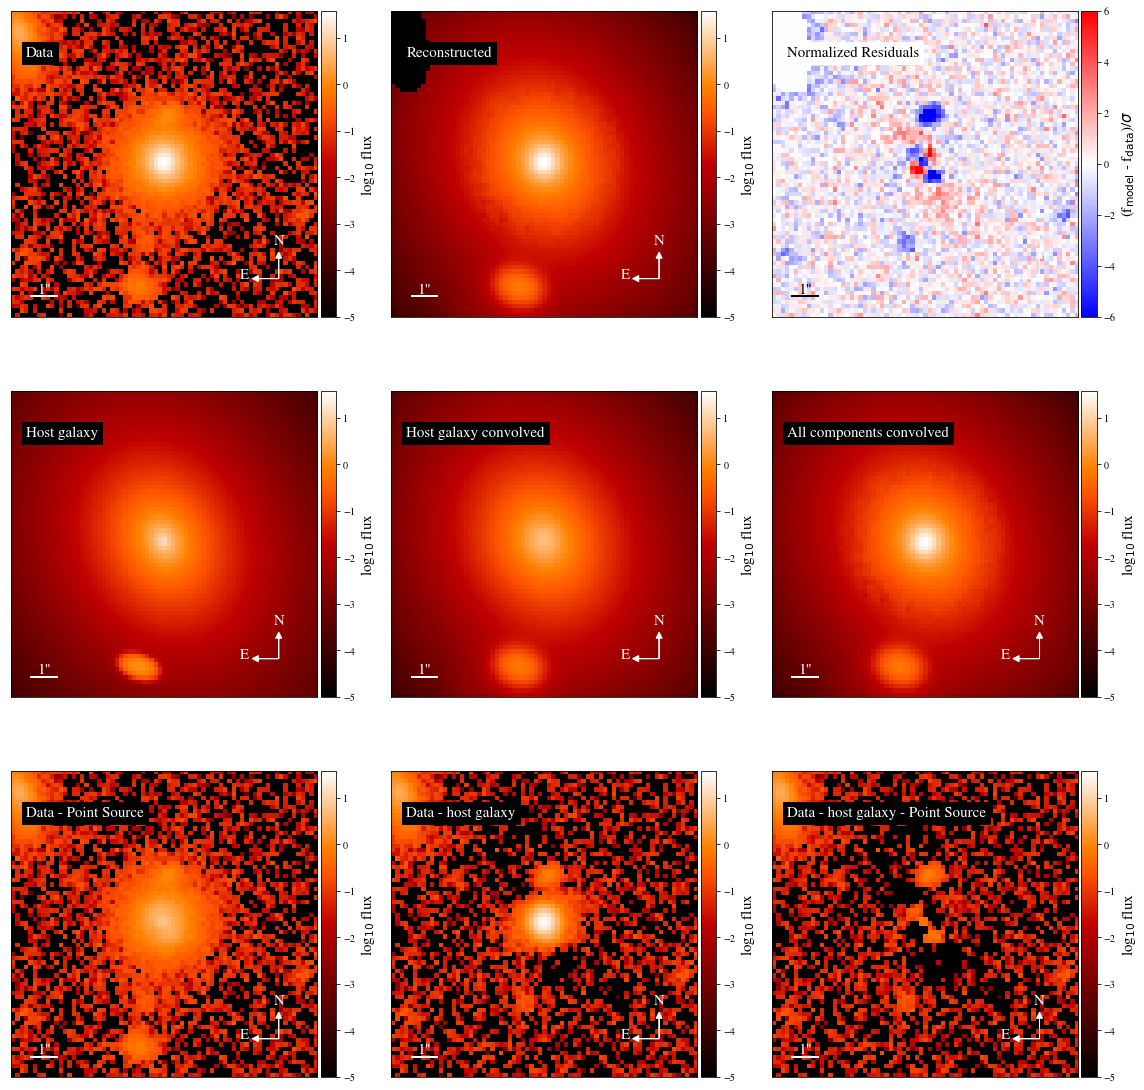

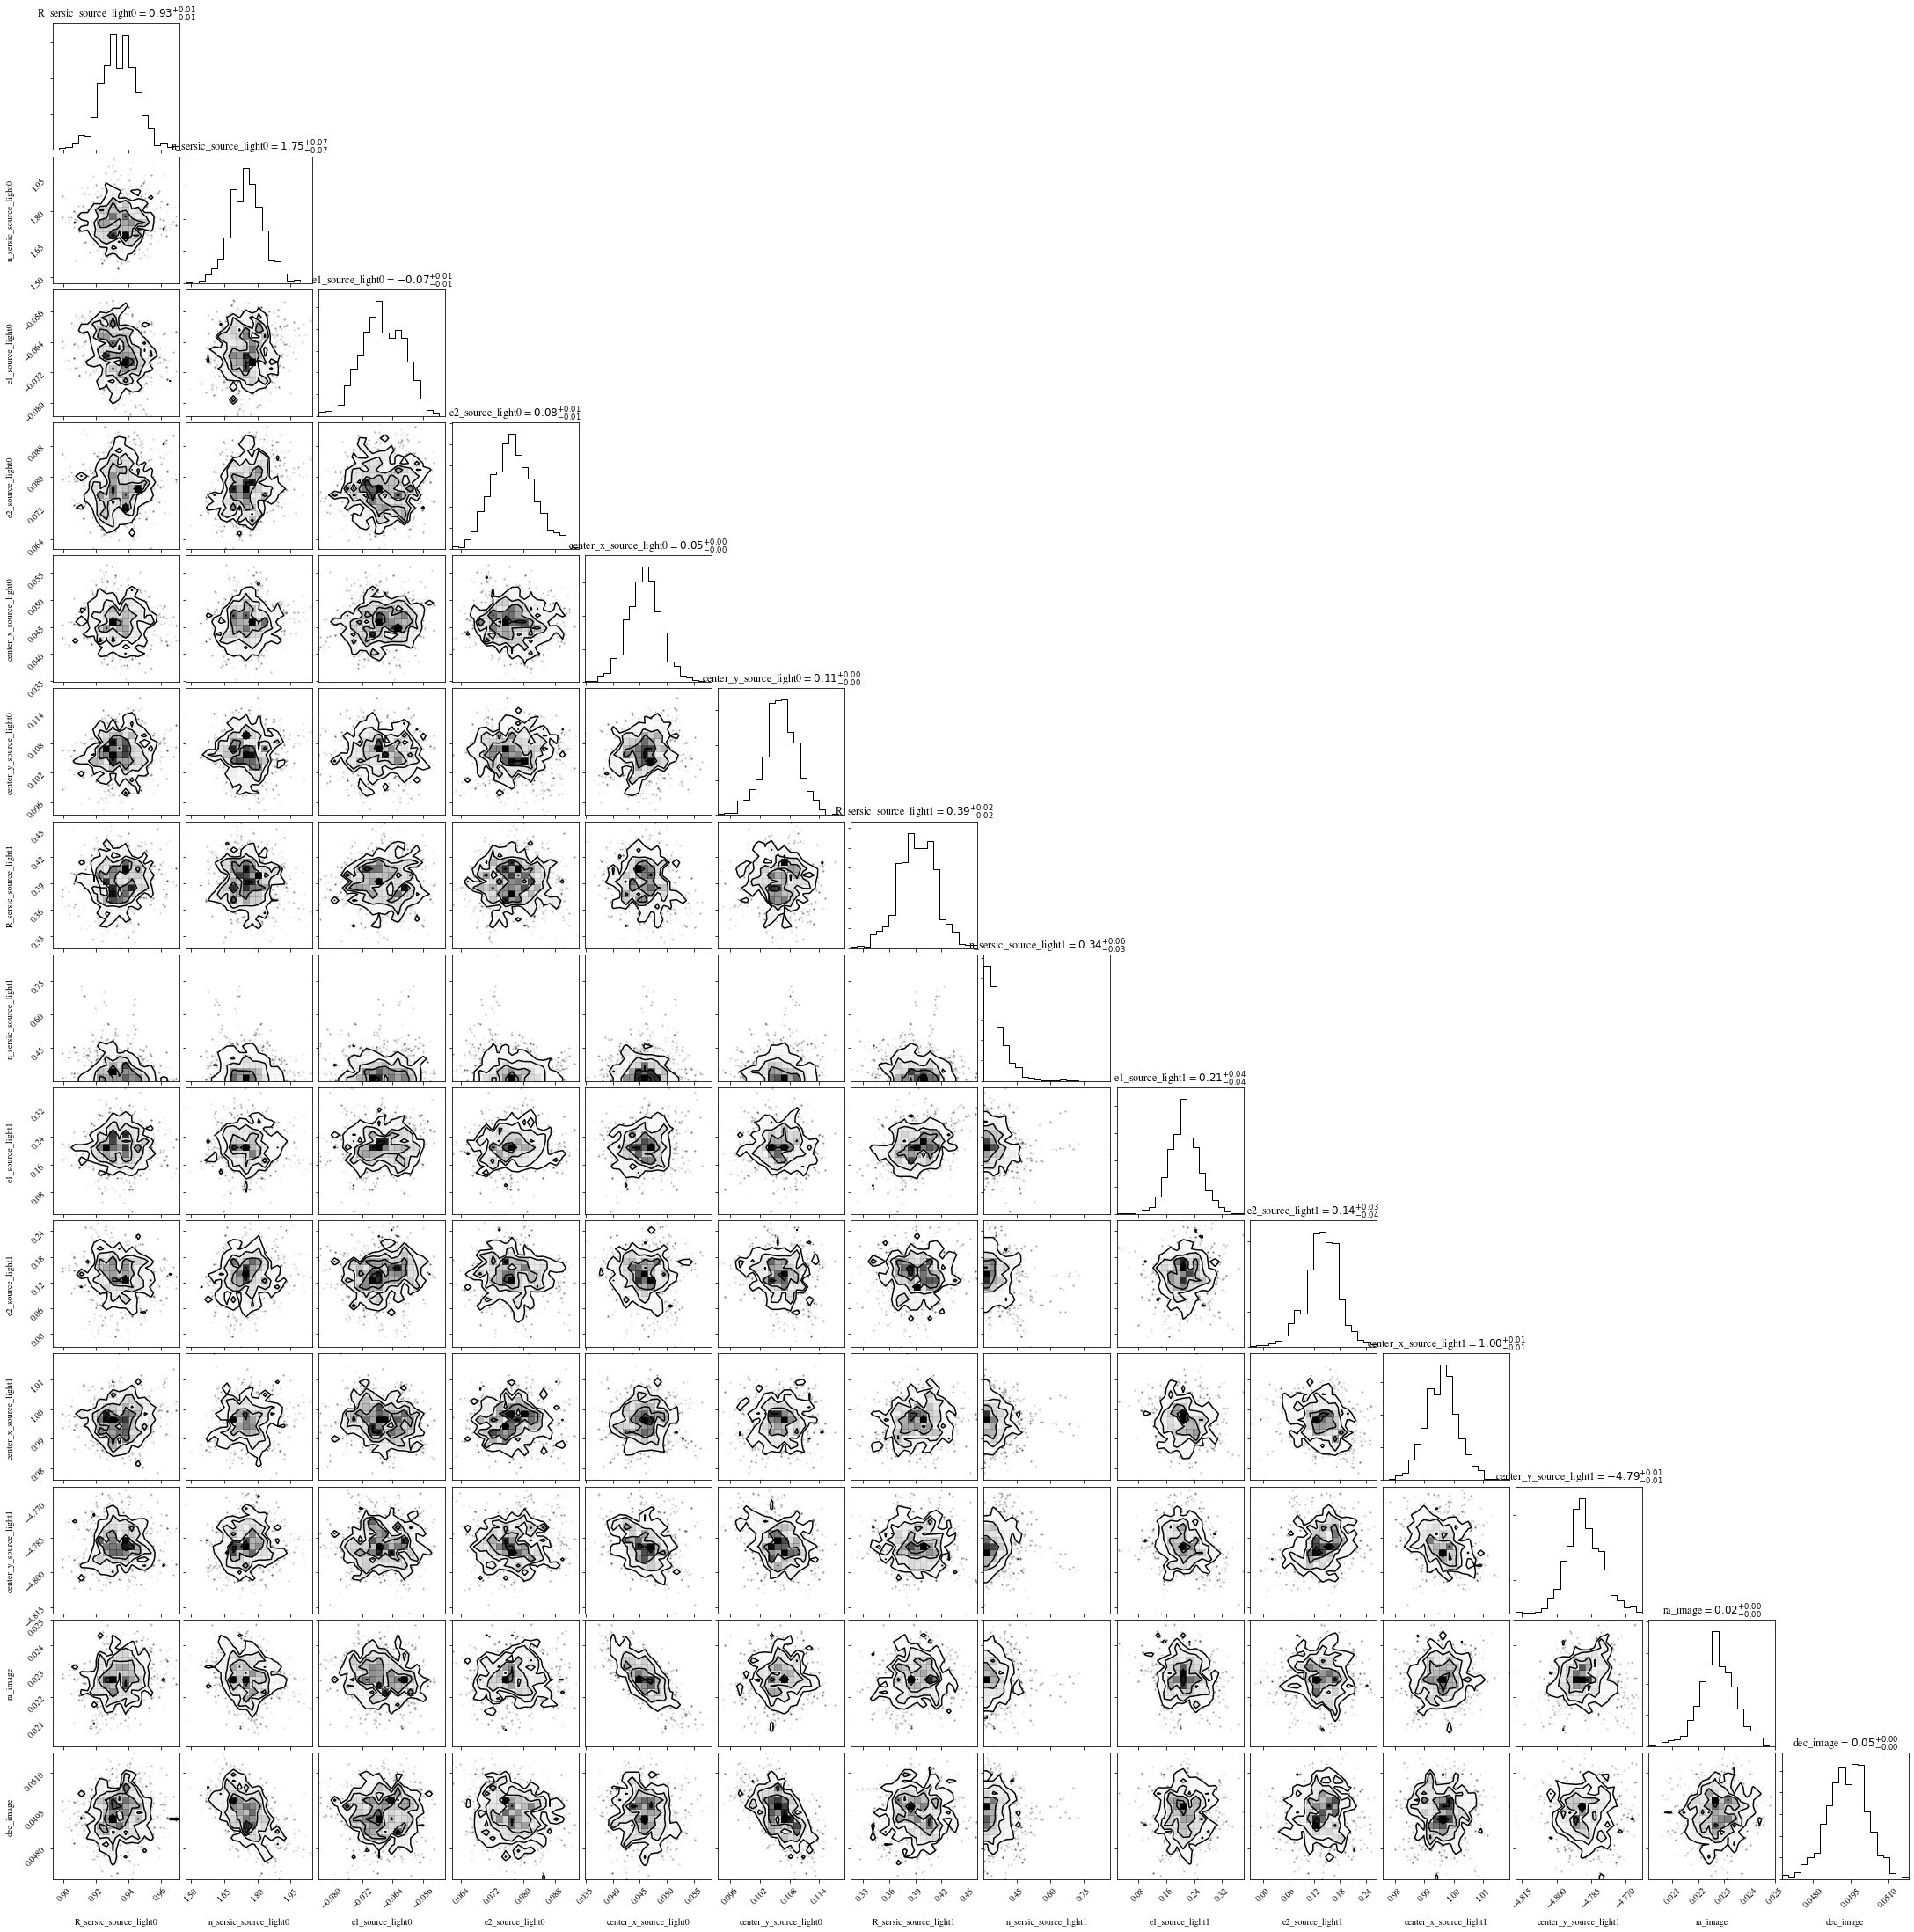

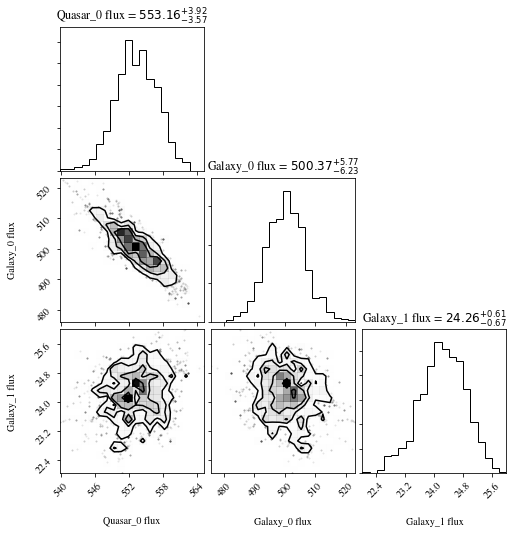

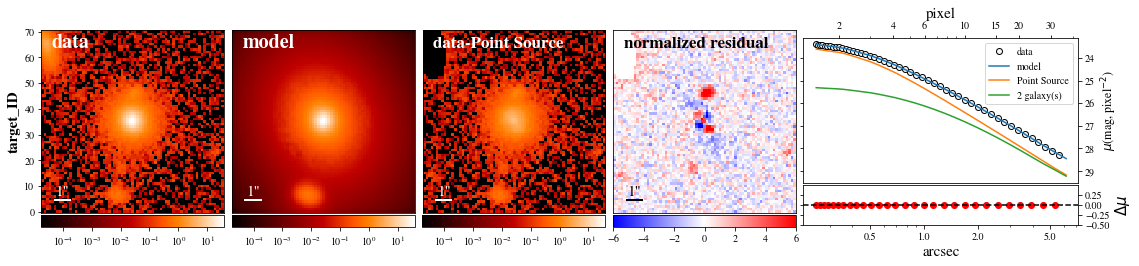

In [6]:
#Setting the fitting method and run.
from decomprofile.fitting_process import FittingProcess

#Pass fit_sepc to FittingProcess,
# savename: The name of the saved files.    
fit_run = FittingProcess(fit_sepc, savename = 'HSC_result')

#Setting the fitting approach and Run: 
#     algorithm_list: The fitting approaches that would be used: e.g. ['PSO', 'PSO', 'MCMC']
#     setting_list: The detailed setting for the fitting: e.g. [[0.8, 50, 50], [0.8, 50, 50], [50, 100, 10, 0.1]]
#     -for PSO:
#         [0.8, 50, 50] would input: {'sigma_scale': 0.8, 'n_particles': 50, 'n_iterations': 50}
#     -for MCMC:
#         [50, 100, 10, 0.1] would input: {'n_burn': 50, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}
#     if setting_list = [None, None, None], default values would be given 
fit_run.run(algorithm_list = ['PSO', 'MCMC'], setting_list = [None, None])

# Plot all the fitting results, including:
#         run_diag() : The convergence of the chains.
#         model_plot(): The model plot (by lenstronomy)
#         plot_params_corner(): The mcmc corner for all the chains (MCMC should be peformed) 
#         plot_flux_corner(): The flux corner for all the component (MCMC should be peformed)
#         plot_final_qso_fit() or plot_final_galaxy_fit(): Plot the overall plot (data, model, data-ps, resudal, 1D profile)
fit_run.plot_all()

#Calculate the magnitude for each component, and translate e1, e1 to q, theta.
fit_run.translate_result()

#Save the fitting class as pickle format:
#     Note, if you use python3 (or 2), load with python3 (or 2)
fit_run.dump_result()

In [9]:
#Load the saved fitting class, the fitting_run_result would be the loaded as fit_run() in previous fittings.
import pickle
picklename = 'HSC_result.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))
#fitting_run_result.plot_final_qso_fit()
fitting_run_result.final_result_galaxy

[{'amp': 45.58586571664983,
  'R_sersic': 0.9418620594381534,
  'n_sersic': 1.7739346803651326,
  'e1': -0.06933945729329305,
  'e2': 0.07883368484948804,
  'center_x': 0.04625133008869715,
  'center_y': 0.1038766582469939,
  'phi_G': 1.146103369362022,
  'q': 0.8099726122906158,
  'flux_sersic_model': 505.49521795835426,
  'flux_within_frame': 502.5680798678835,
  'magnitude': 20.24701274666795},
 {'amp': 31.45221854265555,
  'R_sersic': 0.4069145570530969,
  'n_sersic': 0.3272762575456354,
  'e1': 0.2100267717832619,
  'e2': 0.15650848701029657,
  'center_x': 0.9925772464755809,
  'center_y': -4.7841514113665315,
  'phi_G': 0.32020571098293,
  'q': 0.5848767763554097,
  'flux_sersic_model': 24.84232995599387,
  'flux_within_frame': 24.546278342331227,
  'magnitude': 23.525035863527954}]